# Grad-CAM
## 1. 개요

- 구현 내용: CNN 모델 내 특정 층의 가중치를 시각화하는 Grad CAM을 Inception ResNet V2 모델로 구현합니다.
- 코드 요약: 사진과 모델을 불러오고 예측한 뒤, Grad CAM을 적용하여 예측 시 가중치를 시각화하는 코드입니다.
- 참고 자료: 학교 수업 참고자료 (서울여자대학교)
- 모델 정보: [InceptionResNetV2](https://keras.io/api/applications/inceptionresnetv2/)
- 사진 출처: <a href="https://pixabay.com/ko//?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=3611921">Pixabay</a>로부터 입수된 <a href="https://pixabay.com/ko/users/alexas_fotos-686414/?utm_source=link-attribution&utm_medium=referral&utm_campaign=image&utm_content=3611921">Alexa</a>님의 이미지 입니다.
- 실행 환경: Google Colab 환경에서 실행한 코드입니다.
- 기타 사항: 출력 결과는 말의 종류로 정답을 맞춘 것입니다.

## 2. 코드

In [1]:
# Tensorflow 버전 1 사용
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [2]:
# 필요한 라이브러리 import
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions

In [3]:
# 모델로 Inception ResNet v2 사용
model = InceptionResNetV2(weights='imagenet')

# 모델에 맞게 이미지 변형
img = cv.imread('horse.jpg')
x = np.reshape(cv.resize(img, (299,299)), (1, 299, 299, 3))
x = preprocess_input(x)

# 예측
preds = model.predict(x)
top5 = decode_predictions(preds, top=5)[0]
print('예측 결과: ', top5)

Instructions for updating:
Colocations handled automatically by placer.


225209952/225209952 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


35363/35363 [==============================] - 0s 0us/step
예측 결과:  [('n02389026', 'sorrel', 0.822262), ('n02795169', 'barrel', 0.017709238), ('n04049303', 'rain_barrel', 0.007638285), ('n03124170', 'cowboy_hat', 0.0069805533), ('n04604644', 'worm_fence', 0.0054997304)]


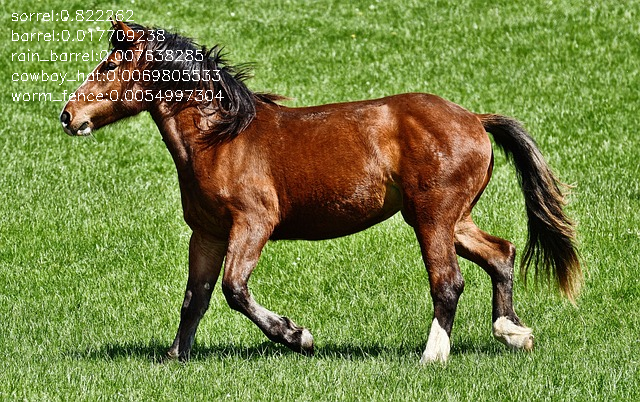

In [4]:
# 예측한 상위 5개의 결과를 이미지에 출력
for i in range(5):
  cv.putText(img, top5[i][1] + ':' + str(top5[i][2]),(10,20+i*20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

cv2_imshow(img)

cv.waitKey()
cv.destroyAllWindows()

In [5]:
# 모델 구조 요약
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_norm

In [6]:
# 가장 높은 값의 인덱스 찾기
np.argmax(preds[0])

339

In [7]:
from keras import backend as K

# 가중치 값 추출
sorrel_output = model.output[:, 339]
# 확인할 층 선정
last_conv_layer_name = "conv_7b_ac"
last_conv_layer = model.get_layer(last_conv_layer_name)

# 그라디언트 값 구하고 정규화
grads = K.gradients(sorrel_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# 그라디언트 값과 마지막 층의 결과값 연산
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

In [8]:
# 히트맵 영상(이미지) 생성
for i in range(1536):
  conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)

  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

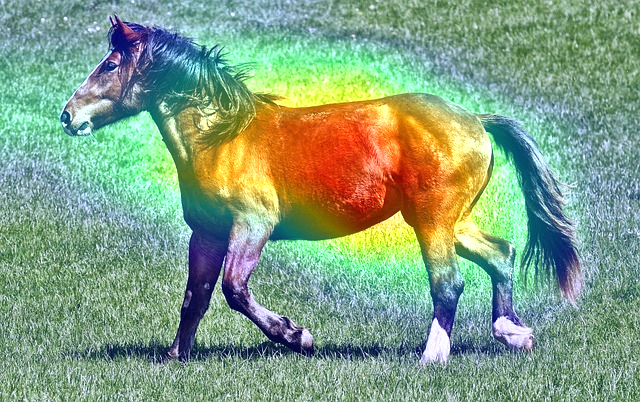

In [9]:
# 말 사진위에 히트맵 추가
img = cv.imread('horse.jpg')
heatmap = cv.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

cv2_imshow(superimposed_img)